In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

In [2]:
seed = 0

In [3]:
X, Y = data.load_german()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = X_train.Sex.values
A_test = X_test.Sex.values

## Model without fairness

Performing a search with Optuna, it will perform a 5-fold cross validation and select the parameters with the best mean score. The score used is the ROC.

In [23]:
model_search = OptunaSearchCV(
    models.XGBoostWrapper(min_child_weight=0),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=25,
    random_state = seed,
    verbose = 0,
)
model_search.fit(X_train, Y_train);


/tmp/ipykernel_236/1506581292.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search = OptunaSearchCV(
[I 2023-11-08 17:54:46,615] A new study created in memory with name: no-name-b9ae1ef1-77be-4c0e-9be4-f731997d5654
[I 2023-11-08 17:54:46,925] Trial 0 finished with value: 0.7502334126218055 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.7502334126218055.
[I 2023-11-08 17:54:47,038] Trial 1 finished with value: 0.749655411150947 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.7502334126218055.
[I 2023-11-08 17:54:47,087] Trial 2 finished with value: 0.5663926043390328 and parameters: {'n_estimators': 5, 'e

In [24]:
utils.eval_model_train_test(
    model_search,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.883123,0.853960,0.146040,0.408655,0.653865,0.830961,0.905512,train_g0
1,0.867579,0.805195,0.194805,0.466299,0.653865,0.798319,0.873239,train_g1
2,0.764912,0.726316,0.273684,0.491156,0.653865,0.710938,0.862500,test_g0
3,0.761702,0.851064,0.148936,0.555302,0.653865,0.736111,0.769231,test_g1


In [25]:
best_params = model_search.best_params_
best_params

{'n_estimators': 20,
 'eta': 0.2955565898078137,
 'max_leaves': 13,
 'colsample_bytree': 0.6279841937897505,
 'max_depth': 6,
 'l2_weight': 15.18579745739284}

## Model with dual step

In [31]:
m = models.XGBoostWrapper(
        min_child_weight=0, 
        alpha = 1,
        sensitive_idx = 0,
        objective = models.penalize_max_loss_subgroups(0, 1)
    )
m.fit(X_train, Y_train)
utils.eval_model_train_test(m, X_train, Y_train, A_train, X_test, Y_test, A_test)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.765235,0.715347,0.284653,0.583835,0.603123,0.713523,0.862687,train_g0
1,0.771645,0.714286,0.285714,0.606563,0.603123,0.693277,0.791367,train_g1
2,0.695375,0.621053,0.378947,0.597221,0.603123,0.640625,0.855072,test_g0
3,0.724681,0.787234,0.212766,0.616210,0.603123,0.694444,0.755102,test_g1


### Experiment 1

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize ROC. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [32]:
model_search_fair = OptunaSearchCV(
    models.XGBoostWrapper(
        min_child_weight=0, 
        alpha = 1,
        sensitive_idx = 0,
        objective = models.penalize_max_loss_subgroups(0, 1)),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=25,
    random_state = seed,
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_1093/3639426879.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-14 10:16:27,210] A new study created in memory with name: no-name-cb520748-3873-42ae-8659-c1bb50d97db9
[I 2023-11-14 10:16:27,523] Trial 0 finished with value: 0.665166290333701 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.665166290333701.
[I 2023-11-14 10:16:27,691] Trial 1 finished with value: 0.6377856970490899 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.665166290333701.
[I 2023-11-14 10:16:27,794] Trial 2 finished with value: 0.5459648344134951 and parameters: {'n_estimators': 5

In [33]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'n_estimators': 20,
 'eta': 0.40718171231708045,
 'max_leaves': 5,
 'colsample_bytree': 0.8929268274610832,
 'max_depth': 10,
 'l2_weight': 0.31027283810746553}

In [34]:
lambda_values = np.append([0],np.logspace(-3, 2, 14))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XGBoostWrapper(
        alpha=1,
        sensitive_idx = 0,
        min_child_weight = 0,
        objective = models.penalize_max_loss_subgroups(0, lambda_value),
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00,  7.79it/s]


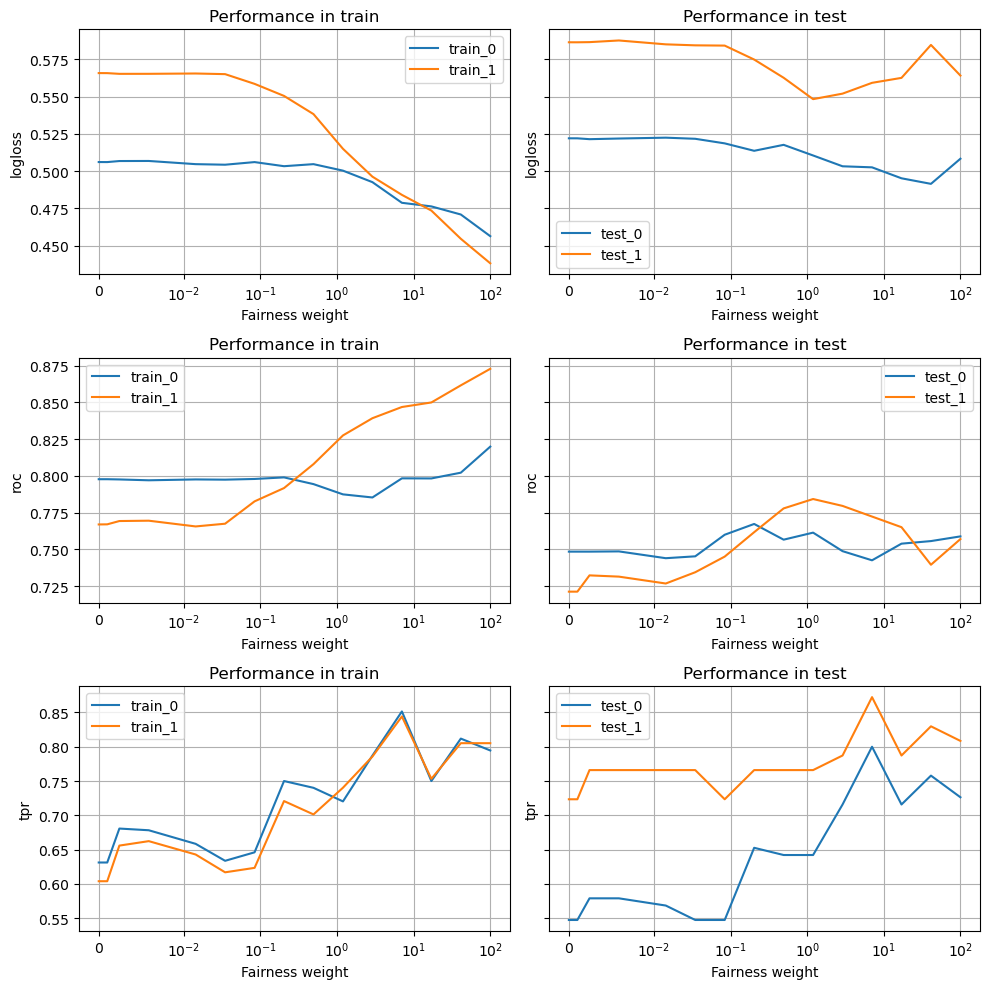

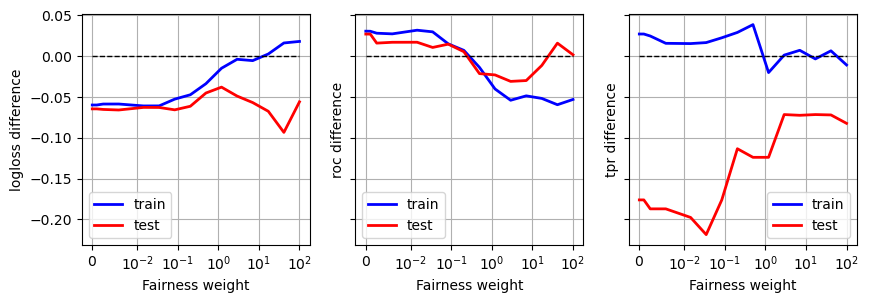

In [35]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 2

- Test different values of fairness weight, and for each, optimize the other parameters to maximize ROC.

In [36]:
lambda_values = np.append([0],np.logspace(-3, 2, 14))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = OptunaSearchCV(
        models.XGBoostWrapper(
            min_child_weight = 0,
            alpha = 1,
            sensitive_idx = 0,
            objective = models.penalize_max_loss_subgroups(0, lambda_value)
        ),
        {
            "n_estimators" : IntDistribution(5, 50, step=3),
            "eta" : FloatDistribution(0.01, 0.5),
            "max_leaves" : IntDistribution(2, 50), 
            "colsample_bytree" : FloatDistribution(0.1, 1),
            "max_depth" : IntDistribution(3, 10),
            "l2_weight" : FloatDistribution(0.01, 100),
        },
        n_trials=25,
        random_state = seed,
        verbose = 0,
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_1093/2827679593.py:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dual_model_ = OptunaSearchCV(
[I 2023-11-14 10:17:07,179] A new study created in memory with name: no-name-2b26d35e-0c11-41cd-9b25-4ce39b43ec19


[I 2023-11-14 10:17:07,608] Trial 0 finished with value: 0.6525186299181834 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.6525186299181834.
[I 2023-11-14 10:17:07,770] Trial 1 finished with value: 0.6159886209551388 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.6525186299181834.
[I 2023-11-14 10:17:07,864] Trial 2 finished with value: 0.5526942280290494 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 0 with value: 0.6525186299181834.
[I 2023-11-14 10:17:08,157] Trial 3 finished with value: 0.6727055898372863 and parameters: {'n_estimators': 20, 'eta': 0

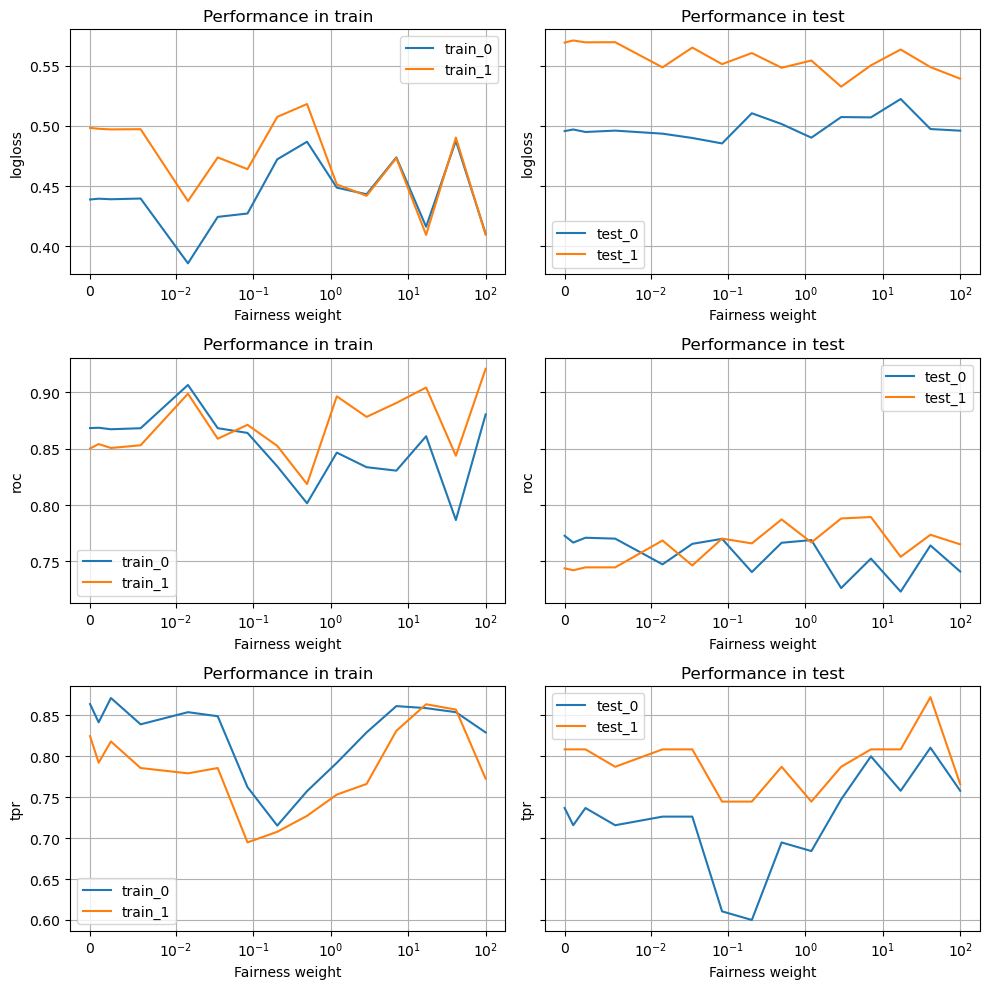

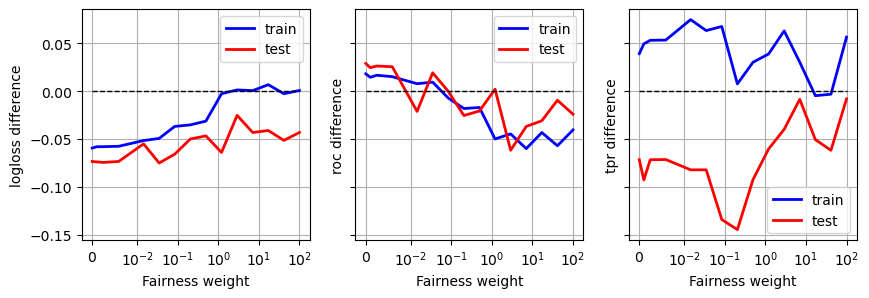

In [37]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 3

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize an weighted sum of ROC and EOD. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [32]:
model_search_fair = OptunaSearchCV(
    models.XGBoostWrapper(
        min_child_weight=0, 
        alpha = 0.5,
        sensitive_idx = 0,
        objective = models.penalize_max_loss_subgroups(0, 1)),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=25,
    random_state = seed,
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_236/206683885.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-08 18:10:37,662] A new study created in memory with name: no-name-e84229cf-789c-4eda-9e74-0ffcc79b1e6e


[I 2023-11-08 18:10:42,281] Trial 0 finished with value: 0.854073268526901 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.854073268526901.
[I 2023-11-08 18:10:44,802] Trial 1 finished with value: 0.8512359708772246 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.854073268526901.
[I 2023-11-08 18:10:46,517] Trial 2 finished with value: 0.7807185202809593 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 0 with value: 0.854073268526901.
[I 2023-11-08 18:10:47,417] Trial 3 finished with value: 0.8332265609293481 and parameters: {'n_estimators': 20, 'eta': 0.483

In [33]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'n_estimators': 23,
 'eta': 0.0746412174169461,
 'max_leaves': 34,
 'colsample_bytree': 0.24776136657853376,
 'max_depth': 8,
 'l2_weight': 84.8426705275996}

In [34]:
utils.eval_model_train_test(
    model_search_fair,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.774776,0.591584,0.408416,0.588125,0.632906,0.661922,0.905303,train_g0
1,0.781192,0.551948,0.448052,0.619908,0.632906,0.651261,0.858586,train_g1
2,0.726316,0.526316,0.473684,0.588915,0.632906,0.609375,0.909091,test_g0
3,0.740000,0.702128,0.297872,0.624457,0.632906,0.708333,0.825000,test_g1


In [35]:
lambda_values = np.append([0],np.logspace(-3, 2, 14))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XGBoostWrapper(
        alpha=0.5,
        sensitive_idx = 0,
        min_child_weight = 0,
        objective = models.penalize_max_loss_subgroups(0, lambda_value),
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)


100%|██████████| 15/15 [00:02<00:00,  5.45it/s]


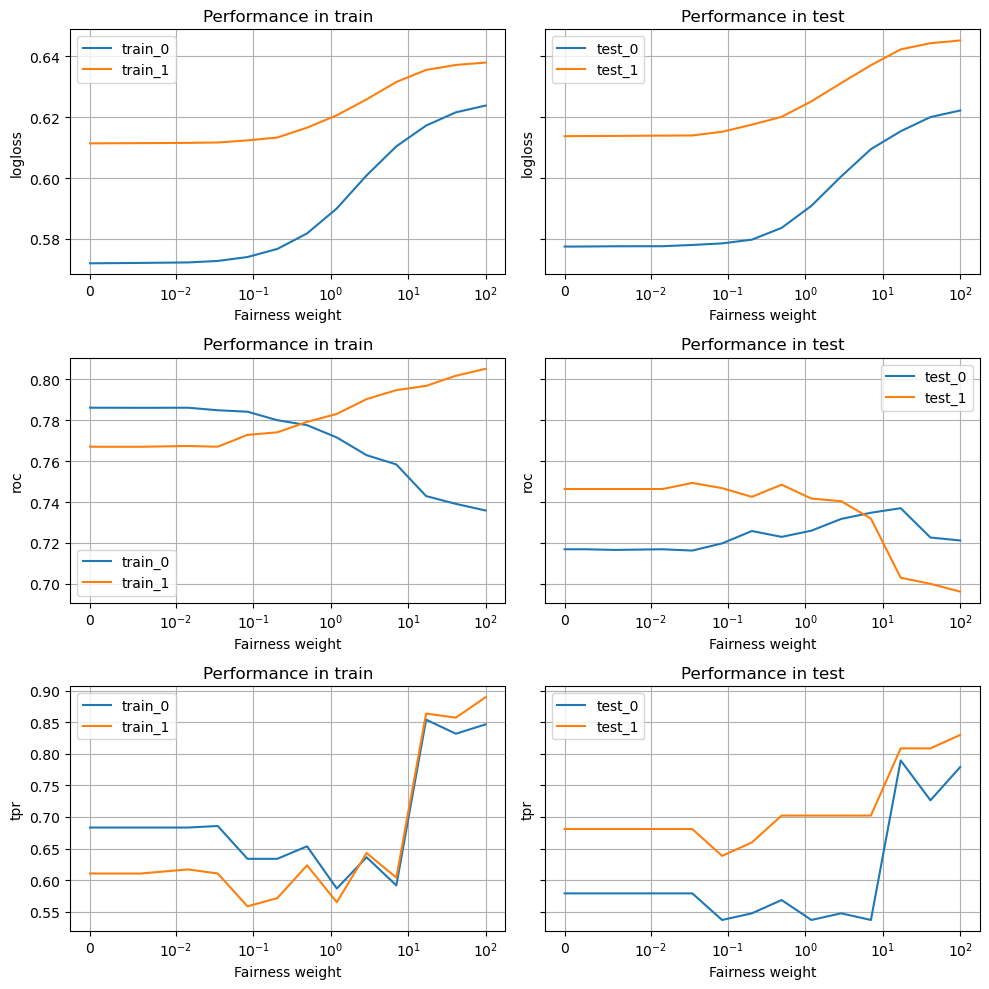

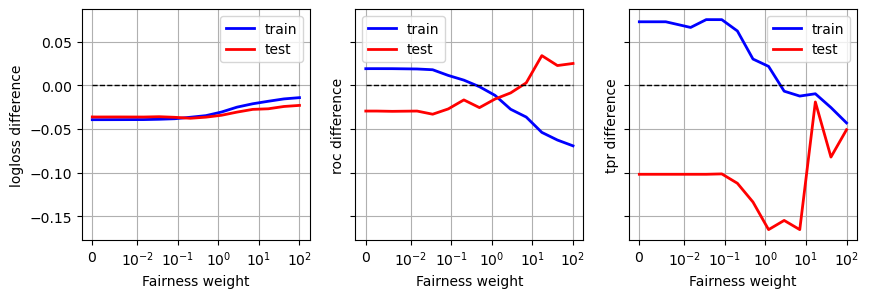

In [36]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 4

In [37]:
lambda_values = np.append([0],np.logspace(-3, 2, 14))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = OptunaSearchCV(
        models.XGBoostWrapper(
            min_child_weight = 0,
            alpha = 0.5,
            sensitive_idx = 0,
            objective = models.penalize_max_loss_subgroups(0, lambda_value)
        ),
        {
            "n_estimators" : IntDistribution(5, 50, step=3),
            "eta" : FloatDistribution(0.01, 0.5),
            "max_leaves" : IntDistribution(2, 50), 
            "colsample_bytree" : FloatDistribution(0.1, 1),
            "max_depth" : IntDistribution(3, 10),
            "l2_weight" : FloatDistribution(0.01, 100),
        },
        n_trials=25,
        random_state = seed,
        verbose = 0,
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_236/1225690494.py:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dual_model_ = OptunaSearchCV(
[I 2023-11-08 18:11:39,149] A new study created in memory with name: no-name-8fc89dcb-1ab1-41f0-badd-174cde64e6d8


[I 2023-11-08 18:11:39,417] Trial 0 finished with value: 0.8558931116453754 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.8558931116453754.
[I 2023-11-08 18:11:39,550] Trial 1 finished with value: 0.8544209825530125 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.8558931116453754.
[I 2023-11-08 18:11:39,661] Trial 2 finished with value: 0.7797509391247777 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 0 with value: 0.8558931116453754.
[I 2023-11-08 18:11:41,413] Trial 3 finished with value: 0.8425719543247675 and parameters: {'n_estimators': 20, 'eta': 0

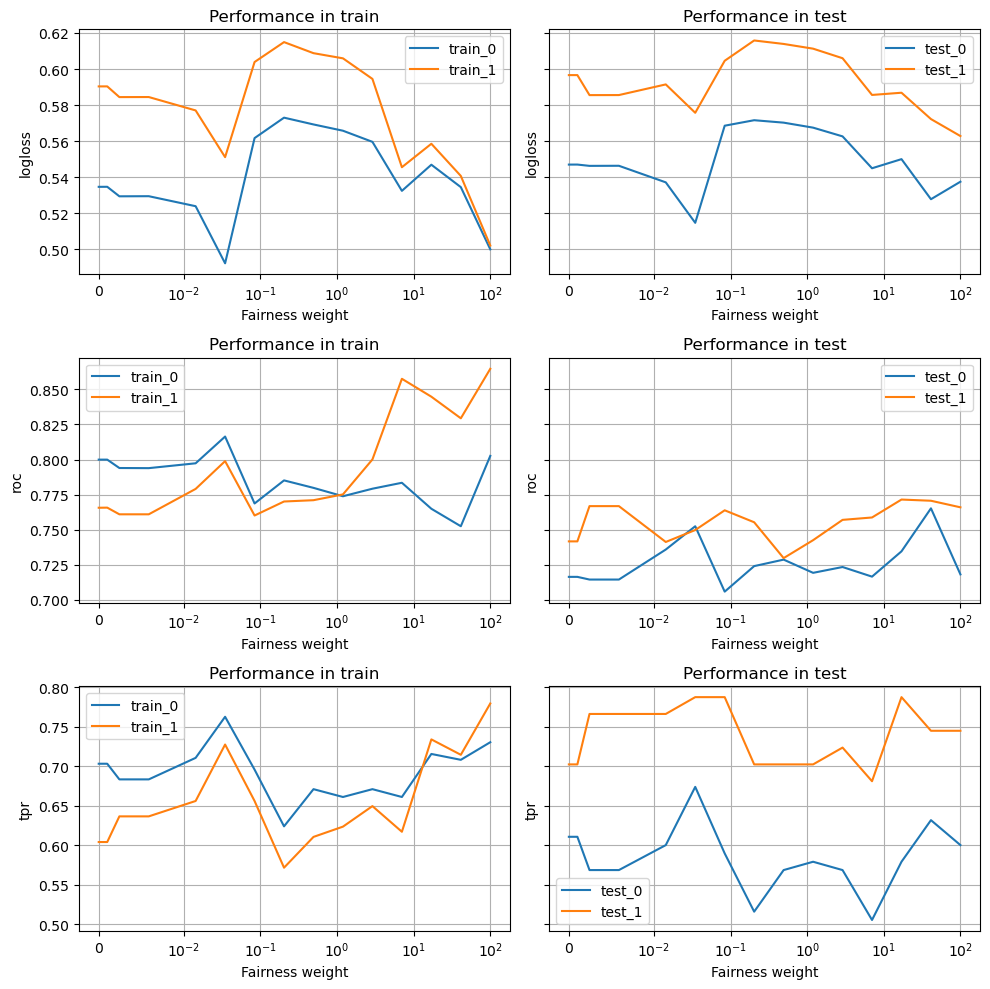

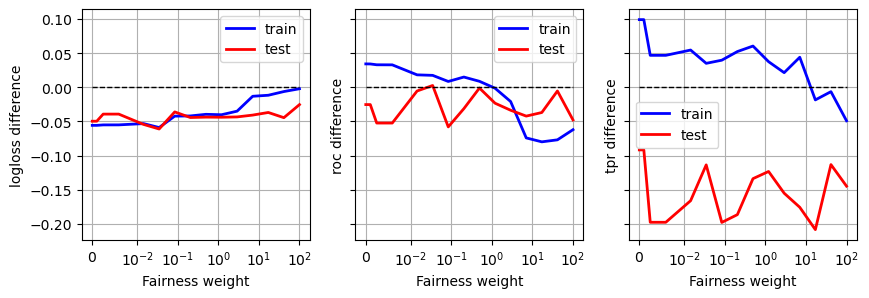

In [38]:
utils.comparison_subgrous_metrics_lambda(results)